In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"


import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

In [2]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten,\
Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import cifar10
import tensorflow.keras.backend as K
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner
import time
# import plotly
# import plotly.express as px

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
latent_dim = 2
# input image dimensions
img_rows, img_cols = 32, 32
img_chn = 1

In [4]:
encoder_inputs = keras.Input(shape=(32, 32, 1))
#first conv
x =  Conv2D(32, 3, strides=2, padding='same', activation=tf.nn.relu)(encoder_inputs)
x =  Conv2D(64, 3, strides=2, padding='same', activation=tf.nn.relu)(x)
x =  Conv2D(128, 3, strides=2, padding='same', activation=tf.nn.relu)(x)
x = Flatten()(x)
z_mean = Dense(latent_dim )(x)
z_log_var = Dense(latent_dim)(x)
z = Sampling(name='sampling_layer')([z_mean, z_log_var])

# self.encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
#         encoder.summary()

# latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(units=4*4*128, activation=tf.nn.relu)(z)
x = Reshape(target_shape=(4, 4, 128))(x)
x = Conv2DTranspose(64, 3, strides=2, padding='same',  activation=tf.nn.relu)(x)
x = Conv2DTranspose(32, 3, strides=2, padding='same',  activation=tf.nn.relu)(x)
dec_out = Conv2DTranspose(img_chn, 3, strides=2, padding='same')(x)


#         decoder.summary()
vae_model = Model(encoder_inputs, dec_out, name="VAE")
vae_model.summary()


Model: "VAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 4, 4, 128)    73856       ['conv2d_1[0][0]']               
                                                                                                

In [5]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation=tf.nn.relu)
        self.conv2 = tf.keras.layers.Conv2D(64, 3, strides=2, padding='same', activation=tf.nn.relu)
        self.conv3 = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same', activation=tf.nn.relu)
        self.flat1 = tf.keras.layers.Flatten()
        self.dens1 = tf.keras.layers.Dense(2)
        self.dens2 = tf.keras.layers.Dense(2)
        self.sampl = Sampling()
        self.decIn = tf.keras.layers.InputLayer(input_shape=(2,))
        self.dens3 = tf.keras.layers.Dense(units=4*4*128, activation=tf.nn.relu)
        self.resh1 = tf.keras.layers.Reshape(target_shape=(4, 4, 128))
        self.deco1 = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same',  activation=tf.nn.relu)
        self.deco2 = tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same',  activation=tf.nn.relu)
        # No activation
        self.deco3 = tf.keras.layers.Conv2DTranspose(img_chn, 3, strides=2, padding='same')
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flat1(x)
        mu = self.dens1(x)
        va = self.dens2(x)
        z = self.sampl([mu,va])
        x = self.decIn(z)
        x = self.dens3(x)
        x = self.resh1(x)
        x = self.deco1(x)
        x = self.deco2(x)
        x = self.deco3(x)
        return x

In [6]:
# m = MyModel()

In [7]:
# m.build(input_shape=(None,32,32,1))

In [8]:
# m.summary()

In [9]:
class Encoder(tf.keras.Model):
    def __init__(self,):
        super(Encoder, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation=tf.nn.relu, input_shape=(32,32,1))
        self.conv2 = tf.keras.layers.Conv2D(64, 3, strides=2, padding='same', activation=tf.nn.relu)
        self.conv3 = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same', activation=tf.nn.relu)
        self.flat1 = tf.keras.layers.Flatten()
        self.dens1 = tf.keras.layers.Dense(2)
        self.dens2 = tf.keras.layers.Dense(2)
        self.sampl = Sampling()
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flat1(x)
        mu = self.dens1(x)
        va = self.dens2(x)
        z = self.sampl([mu,va])
        
        return mu, va, z
    
    def model(self):
        x = Input(shape=(32,32,1))
        return Model(inputs=[x], outputs=self.call(x))
    
class Decoder(tf.keras.Model):
    def __init__(self, ):
        super(Decoder, self).__init__()
        self.dens3 = tf.keras.layers.Dense(units=4*4*128, activation=tf.nn.relu, input_shape=(2,))
        self.resh1 = tf.keras.layers.Reshape(target_shape=(4, 4, 128))
        self.deco1 = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same',  activation=tf.nn.relu)
        self.deco2 = tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same',  activation=tf.nn.relu)
        # No activation
        self.deco3 = tf.keras.layers.Conv2DTranspose(img_chn, 3, strides=2, padding='same')
        
    def call(self, inp):
        x = self.dens3(inp)
        x = self.resh1(x)
        x = self.deco1(x)
        x = self.deco2(x)
        x = self.deco3(x)
        return x
    
    def model(self):
        x = Input(shape=(2))
        return Model(inputs=[x], outputs=self.call(x))

In [10]:
class AE(tf.keras.Model):
    def __init__(self,):
        super(AE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def call(self, inp):
        mu, va, z = self.encoder(inp)
        out_decoder = self.decoder(z)
        return z, out_decoder 
    
    def model(self):
        x = Input(shape=(32,32,1))
        return Model(inputs=[x], outputs=self.call(x))
    
    def encode(self, img):
        return self.encoder(img)
    
    def decode(self, z):
        return self.decoder(z)

In [11]:

model = AE() 


In [12]:
model.decoder.model().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 64)         73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 32, 32, 1)        289   

In [13]:
# input image dimensions
img_rows, img_cols = 32, 32
img_chn = 1

# Load CIFAR-10 dataset-
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
if img_chn == 1:
    x_train = x_train.mean(axis=3)                                                                                    
    x_test = x_test.mean(axis=3)           
    
input_shape = (img_rows, img_cols, img_chn)

# Convert datasets to floating point types-
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize the training and testing datasets-
if img_chn == 1:
    x_train = x_train.reshape((x_train.shape[0], \
                                         img_rows, img_rows, img_chn)) / 255.
    x_test = x_test.reshape((x_test.shape[0], \
                                      img_rows, img_rows, img_chn)) / 255.
else:
    x_train = x_train/255.
    x_test = x_test/255.


print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {x_train.shape} & X_test.shape: {x_test.shape}")

load_outlier_detector = True

latent_dim = 2
epochs = 20


Dimensions of training and testing sets are:
X_train.shape: (50000, 32, 32, 1) & X_test.shape: (10000, 32, 32, 1)


In [14]:
a, b, c = model.encode(x_train[0].reshape(1, 32, 32, 1))

In [15]:
d = model.decode(c)

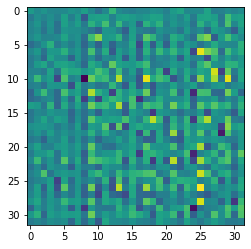

In [16]:
%matplotlib inline
plt.imshow(d[0])